In [3]:
'''
Description:
    Loads precomputed curvature scores from calc_curv_fz_models.py
    on Feldman and Zhang[1] Small Inception models [2] for ratio 0.7 and averages over 1000 models
    to generate curvature vs memorization graph

Reference:
[1] Feldman, V. and Zhang, C. What neural networks memorize and why: Discovering the long tail via influence estimation. 
Advances in Neural Information Processing Systems, 33:2881-2891, 2020.
[2] Feldman, V. and Zhang, C. project website https://pluskid.github.io/influence-memorization/
'''

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Specify the path to the config JSON file
json_file_path = 'config.json'

# Open and read the JSON file
with open(json_file_path, 'r') as json_file:
    # Load the JSON data into a Python dictionary
    config = json.load(json_file)

h = 1e-3
dataset = 'CIFAR100'
save_mem_dir = config['fz_precomputed_score_dir'][dataset.lower()]
fz_model_root_dir = config['fz_model_dir'][dataset.lower()]

scores_curve = []
masks = []
correctness = []

# Convert dataset order from tensorflow to pytorch. Needed because FZ use tensorflow, while this repo uses Pytorch
tf_2_torch_idx = pd.read_pickle("./dataset_idxs/cifar100/tf_id_2_torch_id.pkl")
tf_2_torch_idx = tf_2_torch_idx['torch_id'].to_numpy()
for ratio in ["0.7"]:
    for exp_idx in range(1000):
        model_name = f"{dataset.lower()}_small_inception_{ratio}_{exp_idx}"
        directory_path = os.path.join(save_mem_dir, model_name)
        scores_file_name = f"curv_scores_{model_name}_{h}.pt"
        labels_file_name = f"true_labels_{model_name}_{h}.pt"
        scores = torch.load(os.path.join(directory_path, scores_file_name))
        labels = torch.load(os.path.join(directory_path, labels_file_name))
        
        tf_order_scores = scores[tf_2_torch_idx]
        tf_order_labels = labels[tf_2_torch_idx]
        array = np.load(os.path.join(fz_model_root_dir, str(ratio), str(exp_idx), "aux_arrays.npz"), allow_pickle=True)
        subset_idx = array["index_train"]
        mask = np.zeros(len(tf_order_scores))
        mask[subset_idx] = 1
        correct = np.ones_like(mask) * -1
        removed_idx = array['index_removed']
        correct[removed_idx] = array['correctness_removed'].astype(correct.dtype)
        scores_curve.append(tf_order_scores.numpy())
        masks.append(mask)
        correctness.append(correct)

    scores_curve = np.row_stack(scores_curve)
    masks = np.row_stack(masks)
    correctness = np.row_stack(correctness)
    avg_score = (scores_curve * masks).max(0)

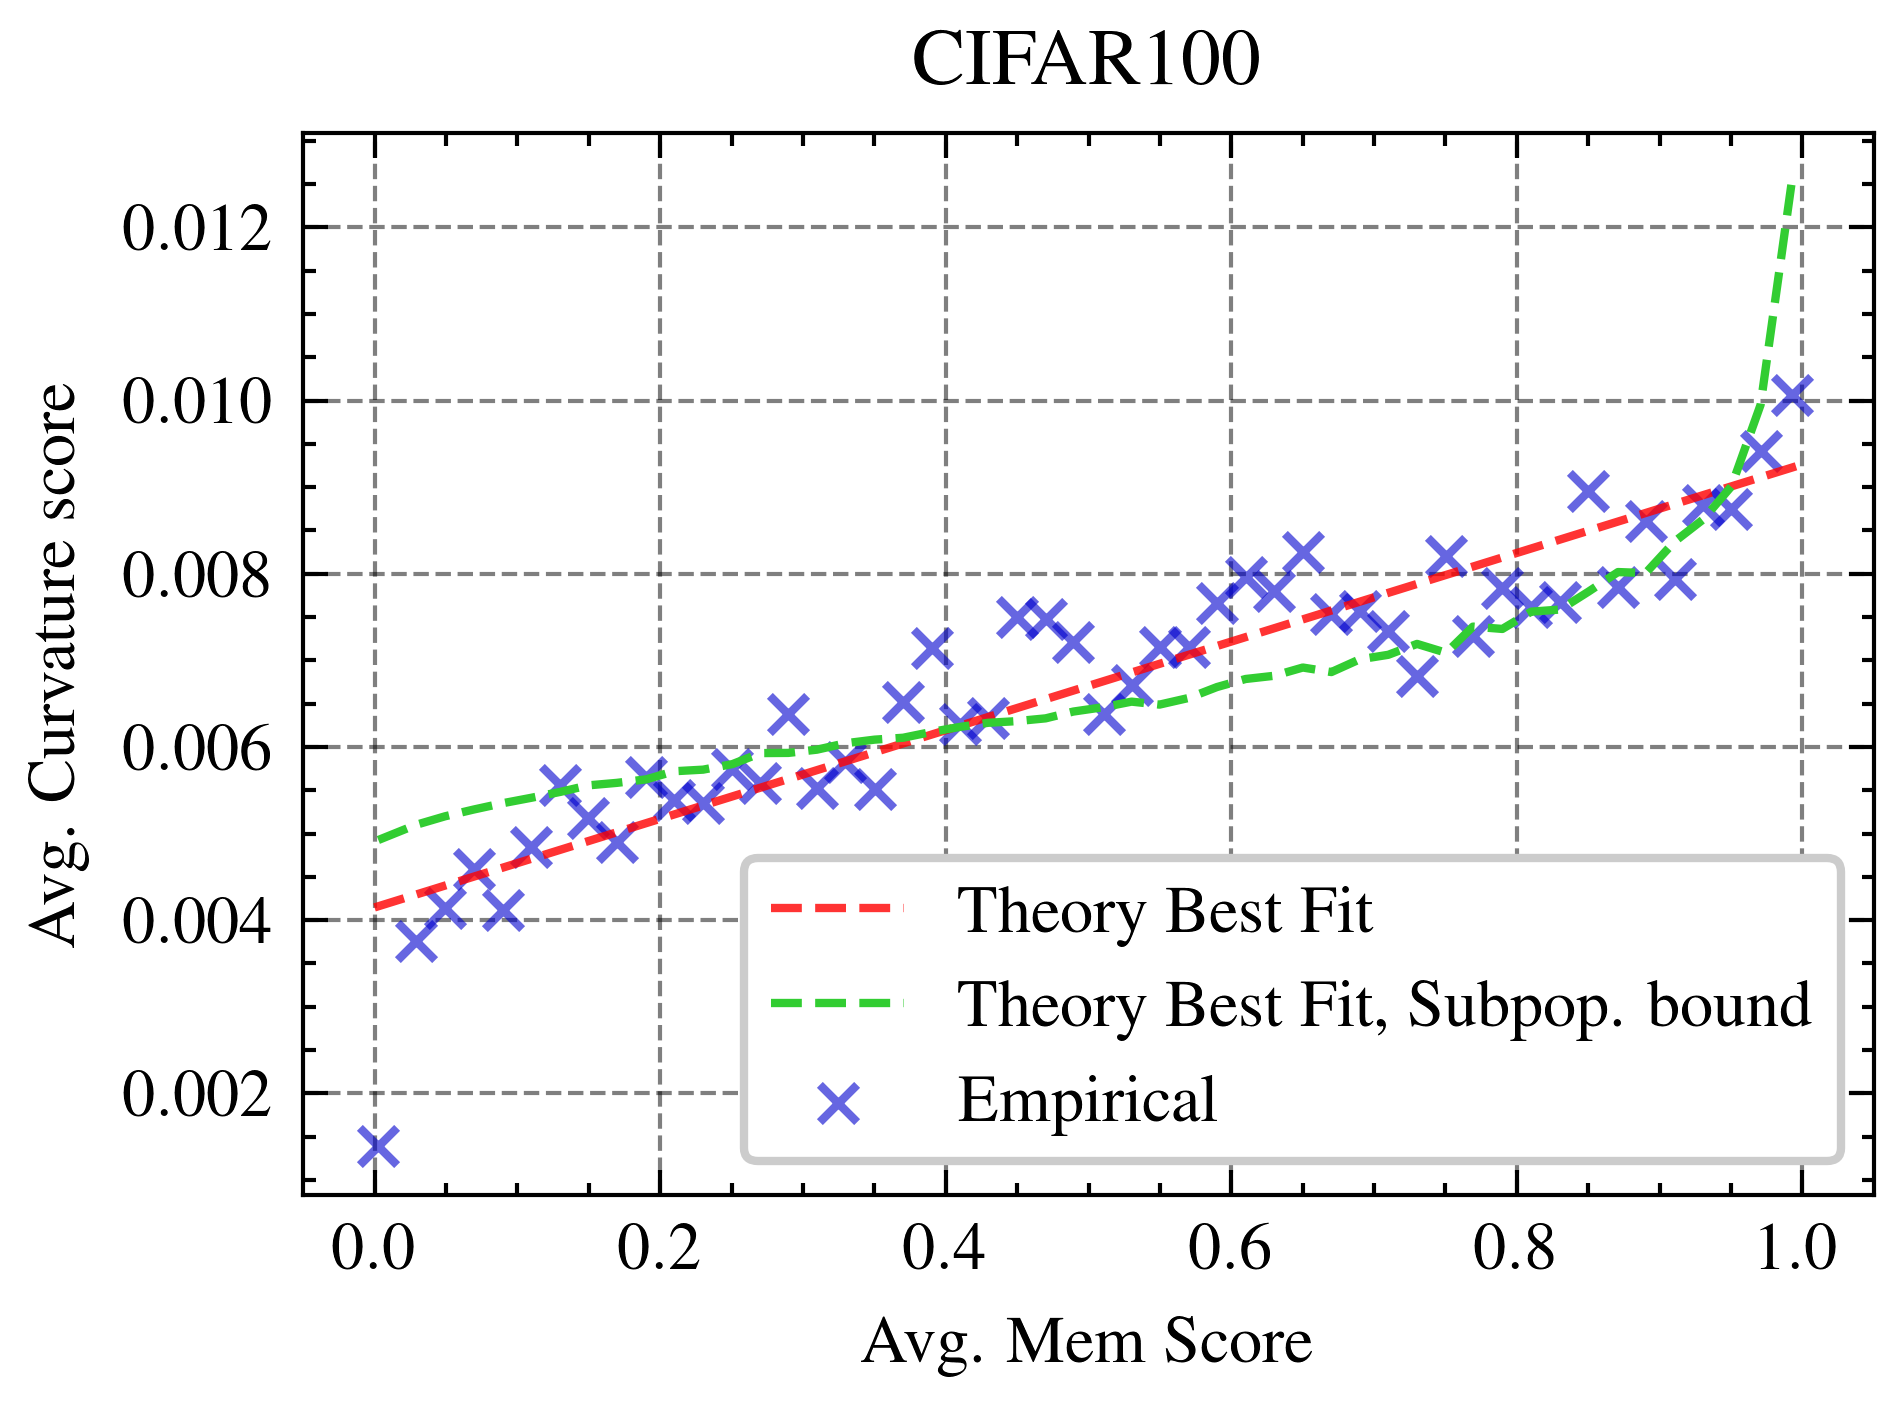

In [4]:
import scienceplots
from sklearn.linear_model import LinearRegression
plt.style.use(['ieee', 'science', 'grid'])

avg_score = (scores_curve * masks).max(0)
correct_rem = (correctness * (1-masks))
acc = correct_rem.sum(0) / (1-masks).sum(0)

# This is the file from Feldman and Zhang[1] see first code block for reference
npz = np.load('./analysis_checkpoints/cifar100/cifar100_infl_matrix.npz', allow_pickle=True)
fz_scores = pd.DataFrame.from_dict({item: npz[item] for item in ['tr_labels', 'tr_mem']})
tf_order_fz = fz_scores.iloc[tf_2_torch_idx]['tr_mem'].to_numpy()
fz_scores['acc'] = acc
df = pd.DataFrame(data={''})

# Configure plots to be pretty and to enable direct usage in the paper
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
fz_scores = fz_scores.iloc[tf_2_torch_idx]
fz_scores['tr_curv'] = avg_score
bin_width = 0.02
fz_avg = []
curv_avg = []
curv_error = []
counts = []
acc = []
for bin_start in np.arange(0, 1, step=bin_width):
    in_bin = np.logical_and(fz_scores['tr_mem'].to_numpy() >= bin_start, fz_scores['tr_mem'].to_numpy() < (bin_start + bin_width))
    idxs_4_bin = np.where(in_bin)
    bin_scores = fz_scores.iloc[idxs_4_bin]
    fz_avg.append(bin_scores['tr_mem'].mean())
    curv_avg.append(bin_scores['tr_curv'].mean())
    curv_error.append(bin_scores['tr_curv'].std())
    bin_acc = bin_scores['acc'].mean() * 100
    acc.append(bin_acc)
    counts.append(len(bin_scores))

# Plot best fit model from theory
lin_model = LinearRegression(positive=True)
tr_x = np.array(fz_avg)
tr_x2 = np.sqrt(np.array(counts))
tr_x3 = 100 - np.array(acc)
tr_y = np.array(curv_avg)
X = np.column_stack([tr_x * tr_x2, np.array(counts)])
theta = np.polyfit(tr_x, tr_y, 1)
lin_model.fit(X, tr_y)
plot_x = np.linspace(0, 1, 100)
y_line = theta[1] + theta[0] * plot_x

# Plot the results
plt.plot(plot_x, y_line, linestyle='dashed', label=f'Theory Best Fit', c='r', alpha=0.8)
plt.plot(tr_x, lin_model.predict(X), linestyle='dashed', label=f'Theory Best Fit, Subpop. bound', c= 'limegreen')
plt.scatter(fz_avg, curv_avg, c='mediumblue', label="Empirical", alpha=0.6, s=20, marker='x')
plt.legend(loc='lower right')
plt.xlabel('Avg. Mem Score')
plt.ylabel('Avg. Curvature score')
plt.title('CIFAR100')
plt.tight_layout()
plt.savefig("./images/fz_avg_curv_vs_mem.png")